# Overdetermined linear systems

[Chapter 3](https://tobydriscoll.net/fnc-julia/leastsq/overview.html).

Solve $Ax=b$ when $A$ is not square. Two cases

* $x$ is shorter than $b$ -- overdetermined (inconsistent, no solution in general, define approximate solutions)
* $b$ is shorter than $x$ -- underdetermined (infinite number of parameterized solutions, add extra criteria, different kind of regression, not discussed in this course)

## Polynomial regression 

Examples from book section 3.2

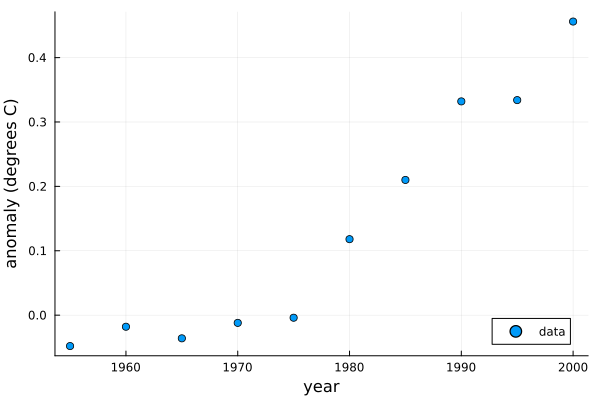

In [41]:
using Plots
year = 1955:5:2000
temp = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
       0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ]
    
scatter(year,temp,label="data",
    xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)

In [42]:
t = @. (year-1950)/10
t = (year .- 1950) ./ 10  # same
t = (year - 1950 ) / 10 # doesn't work
n = length(t)
V = [ t[i]^j for i in 1:n, j in 0:n-1 ]
c = V\temp  # solve Vc = temp

10-element Vector{Float64}:
  -14.114000003719966
   76.36173811538407
 -165.4559722658534
  191.9605667174846
 -133.2734722578299
   58.015577793493335
  -15.962888893287804
    2.6948063499633275
   -0.25466666673964783
    0.01031111111412555

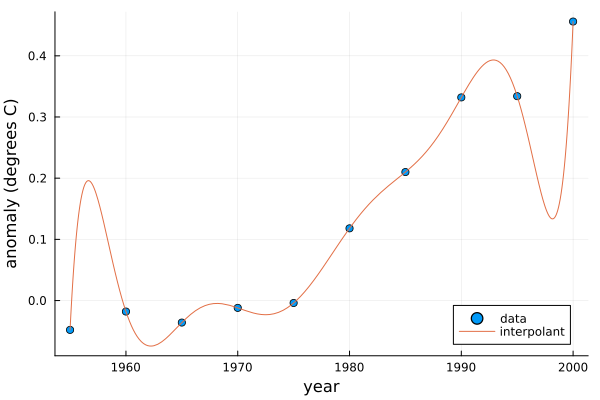

In [43]:
using Polynomials
p = Polynomial(c)
f = yr -> p((yr-1950)/10)
plot!(f,1955,2000,label="interpolant")

Linear regression

In [44]:
V = [ t.^0 t ]    # Vandermonde-ish matrix
@show size(V)
c = V\temp  # What does it mean to solve Vc = temp when c is a vector of 2 numbers and V has 10 rows?
p = Polynomial(c)

size(V) = (10, 2)


Polynomial(-0.18773333333333322 + 0.11670303030303028*x)

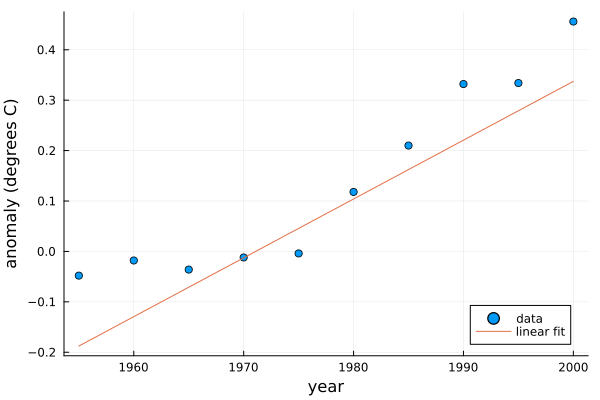

In [45]:
f = yr -> p((yr-1955)/10)
scatter(year,temp,label="data",
    xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)
plot!(f,1955,2000,label="linear fit")

In [57]:
V = [ t[i]^j for i in 1:length(t), j in 0:3 ]   
@show size(V)
p = Polynomial( V\temp )

plot!(f,1955,2000,label="cubic fit")

size(V) = (10, 4)


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/M092a/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/M092a/src/ticks.jl:191


## Least squares perspective

Minimize squared distance between points and line: $\| Ax - b \|$

Solve $A^TAx=A^Tb$. (Normal equations, section 3.2)

In [58]:
V

10×4 Matrix{Float64}:
 1.0  0.5   0.25    0.125
 1.0  1.0   1.0     1.0
 1.0  1.5   2.25    3.375
 1.0  2.0   4.0     8.0
 1.0  2.5   6.25   15.625
 1.0  3.0   9.0    27.0
 1.0  3.5  12.25   42.875
 1.0  4.0  16.0    64.0
 1.0  4.5  20.25   91.125
 1.0  5.0  25.0   125.0

In [60]:
V' * V

4×4 Matrix{Float64}:
  10.0      27.5      96.25     378.125
  27.5      96.25    378.125   1583.31
  96.25    378.125  1583.31    6900.78
 378.125  1583.31   6900.78   30912.6

In [62]:
V' * temp

4-element Vector{Float64}:
   1.3319999999999999
   6.07
  26.926
 120.5695

In [63]:
sol1 = (V' * V) \ V' * temp

4-element Vector{Float64}:
  0.039866666666709946
 -0.17520745920752723
  0.09019580419583173
 -0.007748251748254914

In [48]:
p

Polynomial(0.039866666666668445 - 0.1752074592074616*x + 0.09019580419580508*x^2 - 0.007748251748251838*x^3)

Use Function 3.2.6 to solve this system.

In [49]:
"""
    lsnormal(A,b)

Solve a linear least-squares problem by the normal equations.
Returns the minimizer of ||b-Ax||.
"""
function lsnormal(A,b)
    N = A'*A;  z = A'*b;
    R = cholesky(N).U
    w = forwardsub(R',z)                   # solve R'w=z
    x = backsub(R,w)                       # solve Rx=w
    return x  # solution to R'Rx = z
end

lsnormal

In [50]:
using LinearAlgebra
include("fnc.jl")
sol2 = lsnormal(V, temp)

4-element Vector{Float64}:
  0.03986666666662571
 -0.17520745920738978
  0.09019580419577497
 -0.007748251748248278

In [51]:
cond(V' * V), cond(V), cond(V)^2

(430826.9735539132, 656.3741109710346, 430826.9735530161)

Compare solutions found using three different methods.

In [52]:
@show sol1 .- coeffs(p)
@show sol1 .- sol2
@show coeffs(p) .- sol2;

sol1 .- coeffs(p) = [4.150152443926913e-14, -6.561418075534675e-14, 2.6645352591003757e-14, -3.075664722906879e-15]
sol1 .- sol2 = [8.423817199343375e-14, -1.3744561044859438e-13, 5.676015213396113e-14, -6.6361846573492755e-15]
coeffs(p) .- sol2 = [4.273664755416462e-14, -7.183142969324763e-14, 3.011479954295737e-14, -3.5605199344423966e-15]


## Convergence application

If errors lie on a straight line (possibly log transformed), fit a line to the errors to see rate of convergence.

Approximate $\pi^2/6$ with partial sums of $\sum_{k=1}^{\infty}\frac{1}{k^2}$.

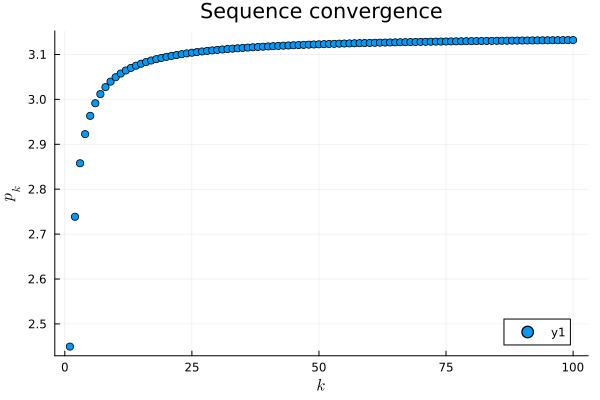

In [53]:
a = [1/k^2 for k=1:100] 
s = cumsum(a)        # cumulative summation
p = @. sqrt(6*s)
p = sqrt.(6 .* s) # works too

using LaTeXStrings
scatter(1:100,p,title="Sequence convergence",
    xlabel=L"k",ylabel=L"p_k")

Compute errors and plot on log scales.

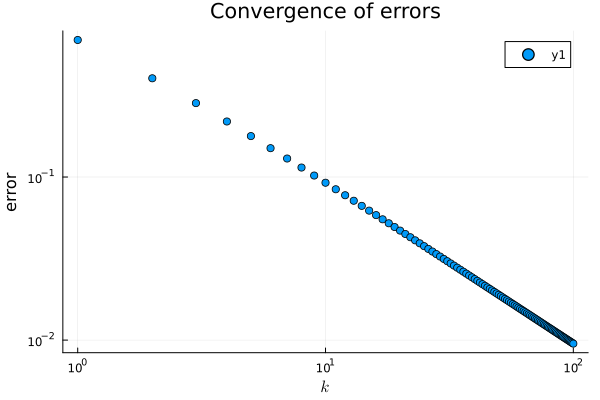

In [54]:
ϵ = @. abs(π-p)    # error sequence
# π  ϵ  ∪ ∩ ÷ ℵ ∞
scatter(1:100,ϵ,title="Convergence of errors",
    xaxis=(:log10,L"k"),yaxis=(:log10,"error"))
# think about what a straight line means here
# log error = a + b log k
# exponentiate
# error = e^a * k^b # power law 

Fit a straight line.

In [55]:
k = 1:100
V = [ k.^0 log.(k) ]     # fitting matrix
c = V \ log.(ϵ)    

2-element Vector{Float64}:
 -0.1823752497283019
 -0.9674103233127926

Add line to plot.

(a, b) = (exp(c[1]), c[2]) = (0.8332885904225771, -0.9674103233127926)


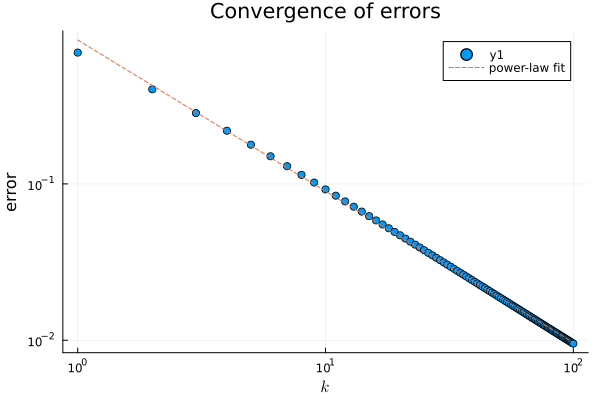

In [56]:
@show a,b = exp(c[1]),c[2];
plot!(k, a*k.^b,l=:dash,label="power-law fit")


## QR factorization

Write $A = QR$ where $Q$ is orthogonal and $R$ is upper triangular. This allows us to solve the linear regression problem quite easily. Read on for how!

Vectors $u$ and $v$ are orthogonal if $u^Tv=0$. A set of vectors $u_i$ are orthogonal if $u_i^Tu_j=0$ for all $i\neq j$. If $u_i^Tu_i=1$ for all $i$ the vectors are orthonormal.

A matrix is orthogonal if it is square and the columns are orthonormal.

Theorem. If $Q$ is orthonormal then:

* $Q^T= Q^{-1}$
* $Q^T$ is orthonormal
* $\kappa(Q) = 2$ using the 2-norm
* If $U$ is orthogonal then $QU$ is orthogonal
* For any $n$ x $n$ matrix $A$, $\|AQ\|_2 = \|A\|_2$.

Every real $m\times n$ matrix $\mathbf{A}$ ($m\ge n$) can be written as $\mathbf{A}=\mathbf{Q}\mathbf{R}$, where $\mathbf{Q}$ is an $m\times m$ orthogonal matrix and $\mathbf{R}$ is an $m\times n$ upper triangular matrix.

Can find $Q$ and $R$ by Gram-Schmidt orthogonalization. The algorithm is unstable so we don't use it.

If the number of rows $m$ is much larger than the number of columns $n$ then a more efficient version is often used. The rows $m+1$ to $n$ of $R$ are zero, so we don't need the columns $m+1$ to $n$ of $Q$. The thin QR factorization has $Q$ as an $m$ x $n$ matrix and $R$ a square $n$ x $n$ matrix.

To solve a least squares problem, we solve $A^TAx = A^Tb$. Writing in QR form gives $R^TQ^TQRx = R^TQ^Tb$. This can be simplified to $R^TRx = R^TQ^Tb$. If the problem is well posed, $A$ has rank at least $m$ and so $R$ is non-singular. Thus we need to solve $Rx = Q^Tb$.

This solution is numerically superior to a direct solution of the normal equations. See Demo 3.2.10 in the text.

The QR decomposition can be computed using Householder reflections: $P = I - 2vv^T$ where $v$ is any unit vector (2-norm). A series of Householder reflections are constructed and then multiplied together to form Q and generate the upper triangular R.

Each Householder reflector is a projection which is used to zero the entries of a column below the diagonal. Start with column 1 and move across the matrix. Reduce the size of the projection matrix P each time so as not to modify columns 1 to i-1.

Sample calculation (adapted from text)

In [64]:
A = rand(float(1:9),6,4)
m,n = size(A)

(6, 4)

In [65]:
A

6×4 Matrix{Float64}:
 8.0  5.0  8.0  4.0
 2.0  2.0  2.0  9.0
 9.0  1.0  5.0  5.0
 1.0  2.0  9.0  5.0
 1.0  2.0  3.0  9.0
 4.0  4.0  6.0  9.0

In [66]:
using LinearAlgebra
function householder_reflector(A,i)
    m, n = size(A)
    z = A[:, i]
    v = normalize(z - norm(z)*[1;zeros(m-1)])
    I - 2*v*v'
end
householder_reflector(A, 1)

6×6 Matrix{Float64}:
 0.619059    0.154765   0.696441   0.0773823   0.0773823   0.309529
 0.154765    0.937124  -0.282942  -0.031438   -0.031438   -0.125752
 0.696441   -0.282942  -0.27324   -0.141471   -0.141471   -0.565885
 0.0773823  -0.031438  -0.141471   0.984281   -0.015719   -0.0628761
 0.0773823  -0.031438  -0.141471  -0.015719    0.984281   -0.0628761
 0.309529   -0.125752  -0.565885  -0.0628761  -0.0628761   0.748496

In [67]:
P1 = householder_reflector(A, 1) 
A = P1 * A

6×4 Matrix{Float64}:
 12.9228        5.64891   11.53      11.2204
  1.11022e-16   1.73637    0.565885   6.06656
  8.88178e-16  -0.186343  -1.45352   -8.20048
 -1.11022e-16   1.86818    8.28294    3.53328
 -1.66533e-16   1.86818    2.28294    7.53328
 -4.44089e-16   3.47274    3.13177    3.13312

In [68]:
P2 = householder_reflector(A[2:end, 2:end], 1) 
A[2:end, :] = P2 * A[2:end, :]

5×4 Matrix{Float64}:
 -4.32653e-16   4.69998       6.78051   9.2802
  8.53994e-16   2.24164e-17  -1.06276  -7.99841
  2.31696e-16  -2.17787e-16   4.36541   1.50749
  1.76185e-16  -2.17787e-16  -1.63459   5.50749
  1.92985e-16  -2.62813e-16  -4.15048  -0.632594

In [69]:
P2

5×5 Matrix{Float64}:
  0.369442   -0.0396476   0.397488    0.397488    0.738883
 -0.0396476   0.997507    0.0249928   0.0249928   0.0464587
  0.397488    0.0249928   0.749434   -0.250566   -0.465773
  0.397488    0.0249928  -0.250566    0.749434   -0.465773
  0.738883    0.0464587  -0.465773   -0.465773    0.134183

In [70]:
P3 = householder_reflector(A[3:end, 3:end], 1)
A[3:end, :]  = P3 * A[3:end, :]

4×4 Matrix{Float64}:
 -1.55596e-16   7.4589e-17    6.33124       1.37481
  8.27756e-16  -2.48589e-16  -1.3687e-15   -4.02645
 -4.70052e-17  -2.06253e-16   3.70823e-16   7.57963
 -3.73728e-16  -2.33527e-16   5.06759e-16   4.62888

In [71]:
P4 = householder_reflector(A[4:end, 4:end], 1)
A[4:end, :]  = P4 * A[4:end, :]

3×4 Matrix{Float64}:
 -5.5573e-16   -1.68525e-16   1.09394e-15   9.75139
  7.14095e-16  -2.50299e-16  -9.83952e-16  -7.76771e-16
  9.10756e-17  -2.60426e-16  -3.20602e-16  -1.18403e-15

In [72]:
A

6×4 Matrix{Float64}:
 12.9228        5.64891      11.53         11.2204
 -4.32653e-16   4.69998       6.78051       9.2802
 -1.55596e-16   7.4589e-17    6.33124       1.37481
 -5.5573e-16   -1.68525e-16   1.09394e-15   9.75139
  7.14095e-16  -2.50299e-16  -9.83952e-16  -7.76771e-16
  9.10756e-17  -2.60426e-16  -3.20602e-16  -1.18403e-15

Use the QR decomposition to solve a linear system.

In [92]:
t = @. (year-1950)/10
n = length(t)
V = [ t[i]^j for i in 1:n, j in 0:1 ]
c = V\temp # Julia's built-in solve 

2-element Vector{Float64}:
 -0.18773333333333322
  0.11670303030303028

In [93]:
cond(V)

7.260570147616136

In [94]:
V

10×2 Matrix{Float64}:
 1.0  0.5
 1.0  1.0
 1.0  1.5
 1.0  2.0
 1.0  2.5
 1.0  3.0
 1.0  3.5
 1.0  4.0
 1.0  4.5
 1.0  5.0

In [95]:
V_qr = qr(V)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor:
10×10 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}:
 -0.316228  -0.495434   -0.338335    …  -0.260431   -0.244851    -0.22927
 -0.316228  -0.385337   -0.237497        0.331701    0.445541     0.55938
 -0.316228  -0.275241    0.899444       -0.0139323   0.00339248   0.0207173
 -0.316228  -0.165145   -0.0869747      -0.0482113  -0.0404586   -0.0327059
 -0.316228  -0.0550482  -0.0733932      -0.0824903  -0.0843097   -0.0861291
 -0.316228   0.0550482  -0.0598117   …  -0.116769   -0.128161    -0.139552
 -0.316228   0.165145   -0.0462303      -0.151048   -0.172012    -0.192975
 -0.316228   0.275241   -0.0326488       0.814673   -0.215863    -0.246399
 -0.316228   0.385337   -0.0190673      -0.219606    0.740286    -0.299822
 -0.316228   0.495434   -0.00548587     -0.253885   -0.303565     0.646755
R factor:
2×2 Matrix{Float64}:
 -3.16228  -8.69626
  0.0       4.54148

In [83]:
V_qr.Q[:,4]' * V_qr.Q[:,4]

1.0

In [84]:
V_qr.Q * V_qr.Q'

10×10 Matrix{Float64}:
  1.0           5.55112e-17   0.0          …   1.66533e-16  -5.55112e-17
 -1.11022e-16   1.0          -1.66533e-16     -2.77556e-16   2.22045e-16
  1.11022e-16  -1.94289e-16   1.0             -3.88578e-16   1.11022e-16
 -1.66533e-16  -2.77556e-17   0.0              1.11022e-16  -1.11022e-16
 -1.11022e-16  -1.11022e-16   2.77556e-16      5.55112e-17   5.55112e-17
  8.32667e-17   1.11022e-16  -3.26128e-16  …  -1.11022e-16  -2.77556e-17
  8.32667e-17   1.11022e-16  -2.77556e-16      1.11022e-16  -2.77556e-17
  1.04083e-16  -1.11022e-16   0.0             -1.66533e-16  -1.38778e-17
 -9.36751e-17  -1.94289e-16  -1.11022e-16      1.0           6.93889e-17
 -3.1225e-16    1.17961e-16   2.22045e-16      2.22045e-16   1.0

Compare with QR from textbook algorithm

In [85]:
"""
    qrfact(A)

QR factorization by Householder reflections. Returns Q and R.
"""
function qrfact(A)
    m,n = size(A)
    Qt = diagm(ones(m))
    R = float(copy(A))
    for k in 1:n
        z = R[k:m,k]
        w = [ -sign(z[1])*norm(z) - z[1]; -z[2:end] ]
        nrmw = norm(w)
        if nrmw < eps() continue; end    # skip this iteration
        v = w / nrmw;
        # Apply the reflection to each relevant column of A and Q
        for j in 1:n
            R[k:m,j] -= v*( 2*(v'*R[k:m,j]) )
        end
        for j in 1:m
            Qt[k:m,j] -= v*( 2*(v'*Qt[k:m,j]) )
        end
    end
    return Qt',triu(R)
end

qrfact

In [96]:
myQ, myR = qrfact(V);

In [97]:
myQ

10×10 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.316228  -0.495434   -0.338335    …  -0.260431   -0.244851    -0.22927
 -0.316228  -0.385337   -0.237497        0.331701    0.445541     0.55938
 -0.316228  -0.275241    0.899444       -0.0139323   0.00339248   0.0207173
 -0.316228  -0.165145   -0.0869747      -0.0482113  -0.0404586   -0.0327059
 -0.316228  -0.0550482  -0.0733932      -0.0824903  -0.0843097   -0.0861291
 -0.316228   0.0550482  -0.0598117   …  -0.116769   -0.128161    -0.139552
 -0.316228   0.165145   -0.0462303      -0.151048   -0.172012    -0.192975
 -0.316228   0.275241   -0.0326488       0.814673   -0.215863    -0.246399
 -0.316228   0.385337   -0.0190673      -0.219606    0.740286    -0.299822
 -0.316228   0.495434   -0.00548587     -0.253885   -0.303565     0.646755

In [98]:
myR

10×2 Matrix{Float64}:
 -3.16228  -8.69626
  0.0       4.54148
  0.0       0.0
  0.0       0.0
  0.0       0.0
  0.0       0.0
  0.0       0.0
  0.0       0.0
  0.0       0.0
  0.0       0.0

In [99]:
sum(abs.(myQ * myR .- V))  # QR is approximately V

2.1038726316646716e-14

In [100]:
sum(abs.(V_qr.Q * V_qr.R .- V))  # QR is approximately V

5.329070518200751e-15

In [89]:
sum(abs.(myR .- V_qr.R)) # there are some differences compared with the LinearAlgebra package QR

6.428587973030384

Solve Vc = b by writing V = QR and solving QRc = b. 
Since Q is orthogonal, we can solve Rc = Q^Tb.
Since R us upper triangular, solve this system by backsubstition.

In [32]:
"""
    backsub(U,b)

Solve the upper triangular linear system with matrix `U` and
right-hand side vector `b`.
"""
function backsub(U,b)
    n = size(U,1)
    x = zeros(n)
    x[n] = b[n]/U[n,n]
    for i in n-1:-1:1
        s = sum( U[i,j]*x[j] for j in i+1:n )
        x[i] = ( b[i] - s ) / U[i,i]
    end
    return x
end

backsub

In [101]:
c1 = backsub(V_qr.R, V_qr.Q' * temp)

2-element Vector{Float64}:
 -0.18773333333333334
  0.11670303030303032

In [102]:
sum(abs.(c1 .- c)) # close to the Julia solution, especially considering the conditioning of V

1.5265566588595902e-16